In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import KFold


from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm


# 1. Loading data

In [2]:
sales = pd.read_csv("C:/Users/SAMSUNG/OneDrive/Documentos/GitHub/cognizant_virtual_experience/data/sales.csv")
stock = pd.read_csv("C:/Users/SAMSUNG/OneDrive/Documentos/GitHub/cognizant_virtual_experience/data/sensor_stock_levels.csv")
temp = pd.read_csv("C:/Users/SAMSUNG/OneDrive/Documentos/GitHub/cognizant_virtual_experience/data/sensor_storage_temperature.csv")

In [3]:
sales.head(3)

,Unnamed: 0,transaction_id,timestamp,product_id,category,customer_type,unit_price,quantity,total,payment_type
0,0,a1c82654-c52c-45b3-8ce8-4c2a1efe63ed,2022-03-02 09:51:38,3bc6c1ea-0198-46de-9ffd-514ae3338713,fruit,gold,3.99,2,7.98,e-wallet
1,1,931ad550-09e8-4da6-beaa-8c9d17be9c60,2022-03-06 10:33:59,ad81b46c-bf38-41cf-9b54-5fe7f5eba93e,fruit,standard,3.99,1,3.99,e-wallet
2,2,ae133534-6f61-4cd6-b6b8-d1c1d8d90aea,2022-03-04 17:20:21,7c55cbd4-f306-4c04-a030-628cbe7867c1,fruit,premium,0.19,2,0.38,e-wallet


In [4]:
stock.head(3)

,Unnamed: 0,id,timestamp,product_id,estimated_stock_pct
0,0,4220e505-c247-478d-9831-6b9f87a4488a,2022-03-07 12:13:02,f658605e-75f3-4fed-a655-c0903f344427,0.75
1,1,f2612b26-fc82-49ea-8940-0751fdd4d9ef,2022-03-07 16:39:46,de06083a-f5c0-451d-b2f4-9ab88b52609d,0.48
2,2,989a287f-67e6-4478-aa49-c3a35dac0e2e,2022-03-01 18:17:43,ce8f3a04-d1a4-43b1-a7c2-fa1b8e7674c8,0.58


In [5]:
temp.head(3)

,Unnamed: 0,id,timestamp,temperature
0,0,d1ca1ef8-0eac-42fc-af80-97106efc7b13,2022-03-07 15:55:20,2.96
1,1,4b8a66c4-0f3a-4f16-826f-8cf9397e9d18,2022-03-01 09:18:22,1.88
2,2,3d47a0c7-1e72-4512-812f-b6b5d8428cf3,2022-03-04 15:12:26,1.78


In [6]:
print(f'Sales shape is:', sales.shape)
print(f'Stock shape is:', stock.shape)
print(f'Temp shape is:', temp.shape)

Sales shape is: (7829, 10)
Stock shape is: (15000, 5)
Temp shape is: (23890, 4)


In [7]:
sales.columns

Index(['Unnamed: 0', 'transaction_id', 'timestamp', 'product_id', 'category',
       'customer_type', 'unit_price', 'quantity', 'total', 'payment_type'],
      dtype='object')

# 2. Data Cleaning

In [8]:
sales = sales.drop(columns=['Unnamed: 0'])

In [9]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7829 entries, 0 to 7828
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   transaction_id  7829 non-null   object 
 1   timestamp       7829 non-null   object 
 2   product_id      7829 non-null   object 
 3   category        7829 non-null   object 
 4   customer_type   7829 non-null   object 
 5   unit_price      7829 non-null   float64
 6   quantity        7829 non-null   int64  
 7   total           7829 non-null   float64
 8   payment_type    7829 non-null   object 
dtypes: float64(2), int64(1), object(6)
memory usage: 550.6+ KB


In [10]:
sales['timestamp'] = pd.to_datetime(sales['timestamp'], format='%Y-%m-%d %H:%M:%S' )

In [11]:
stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           15000 non-null  int64  
 1   id                   15000 non-null  object 
 2   timestamp            15000 non-null  object 
 3   product_id           15000 non-null  object 
 4   estimated_stock_pct  15000 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 586.1+ KB


In [12]:
stock.duplicated().sum()

0

In [13]:
stock = stock.drop(columns=['Unnamed: 0'])

In [14]:
stock['timestamp'] = pd.to_datetime(stock['timestamp'], format='%Y-%m-%d %H:%M:%S' )

In [15]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23890 entries, 0 to 23889
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   23890 non-null  int64  
 1   id           23890 non-null  object 
 2   timestamp    23890 non-null  object 
 3   temperature  23890 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 746.7+ KB


In [16]:
temp = temp.drop(columns=['Unnamed: 0'])

In [17]:
temp['timestamp'] = pd.to_datetime(temp['timestamp'], format='%Y-%m-%d %H:%M:%S' )

# 3. Merging data

The client indicates that they want the model to predict on an hourly basis. To do that we must transform the `timestamp` column in all 3 datasets to be based on the hour of the day, then we can merge the datasets together.

In [18]:
def convert_timestamp_to_hour(data: pd.DataFrame = None, column: str = None):
    dummy = data.copy()
    new_ts = dummy[column].tolist()
    new_ts = [i.strftime('%Y-%m-%d %H:00:00') for i in new_ts]
    new_ts = [datetime.strptime(i, '%Y-%m-%d %H:00:00') for i in new_ts]
    dummy[column] = new_ts
    return dummy


In [19]:
sales = convert_timestamp_to_hour(sales, 'timestamp')
sales.head(3)

,transaction_id,timestamp,product_id,category,customer_type,unit_price,quantity,total,payment_type
0,a1c82654-c52c-45b3-8ce8-4c2a1efe63ed,2022-03-02 09:00:00,3bc6c1ea-0198-46de-9ffd-514ae3338713,fruit,gold,3.99,2,7.98,e-wallet
1,931ad550-09e8-4da6-beaa-8c9d17be9c60,2022-03-06 10:00:00,ad81b46c-bf38-41cf-9b54-5fe7f5eba93e,fruit,standard,3.99,1,3.99,e-wallet
2,ae133534-6f61-4cd6-b6b8-d1c1d8d90aea,2022-03-04 17:00:00,7c55cbd4-f306-4c04-a030-628cbe7867c1,fruit,premium,0.19,2,0.38,e-wallet


In [20]:
stock = convert_timestamp_to_hour(stock, 'timestamp')
temp = convert_timestamp_to_hour(temp, 'timestamp')

The next thing to do, is to aggregate the dataset in toder to combine rows whihc have the same value for `timestamp`.

In [21]:
sales.columns

Index(['transaction_id', 'timestamp', 'product_id', 'category',
       'customer_type', 'unit_price', 'quantity', 'total', 'payment_type'],
      dtype='object')

In [22]:
sales_agg = sales.groupby(['timestamp', 'product_id']).agg({'quantity': 'sum'}).reset_index()
sales_agg.head(5)

,timestamp,product_id,quantity
0,2022-03-01 09:00:00,00e120bb-89d6-4df5-bc48-a051148e3d03,3
1,2022-03-01 09:00:00,01f3cdd9-8e9e-4dff-9b5c-69698a0388d0,3
2,2022-03-01 09:00:00,03a2557a-aa12-4add-a6d4-77dc36342067,3
3,2022-03-01 09:00:00,049b2171-0eeb-4a3e-bf98-0c290c7821da,7
4,2022-03-01 09:00:00,04da844d-8dba-4470-9119-e534d52a03a0,11


In [23]:
stock.columns

Index(['id', 'timestamp', 'product_id', 'estimated_stock_pct'], dtype='object')

In [24]:
stock_agg = stock.groupby(['timestamp', 'product_id']).agg({'estimated_stock_pct': 'mean'}).reset_index()
stock_agg.head(4)

,timestamp,product_id,estimated_stock_pct
0,2022-03-01 09:00:00,00e120bb-89d6-4df5-bc48-a051148e3d03,0.89
1,2022-03-01 09:00:00,01f3cdd9-8e9e-4dff-9b5c-69698a0388d0,0.14
2,2022-03-01 09:00:00,01ff0803-ae73-4234-971d-5713c97b7f4b,0.67
3,2022-03-01 09:00:00,0363eb21-8c74-47e1-a216-c37e565e5ceb,0.82


In [25]:
temp.columns

Index(['id', 'timestamp', 'temperature'], dtype='object')

In [26]:
temp_agg = temp.groupby(['timestamp']).agg({'temperature': 'mean'}).reset_index()
temp_agg.head(5)

,timestamp,temperature
0,2022-03-01 09:00:00,-0.028850
1,2022-03-01 10:00:00,1.284314
2,2022-03-01 11:00:00,-0.560000
3,2022-03-01 12:00:00,-0.537721
4,2022-03-01 13:00:00,-0.188734


In [27]:
merged_df = stock_agg.merge(sales_agg, on = ['timestamp', 'product_id'], how = 'left')
merged_df

,timestamp,product_id,estimated_stock_pct,quantity
0,2022-03-01 09:00:00,00e120bb-89d6-4df5-bc48-a051148e3d03,0.89,3.0
1,2022-03-01 09:00:00,01f3cdd9-8e9e-4dff-9b5c-69698a0388d0,0.14,3.0
2,2022-03-01 09:00:00,01ff0803-ae73-4234-971d-5713c97b7f4b,0.67,NaN
3,2022-03-01 09:00:00,0363eb21-8c74-47e1-a216-c37e565e5ceb,0.82,NaN
4,2022-03-01 09:00:00,03f0b20e-3b5b-444f-bc39-cdfa2523d4bc,0.05,NaN
...,...,...,...,...
10840,2022-03-07 19:00:00,ecac012c-1dec-41d4-9ebd-56fb7166f6d9,0.50,4.0
10841,2022-03-07 19:00:00,ed7f6b14-67c9-42a4-8576-c803020eedda,0.26,NaN
10842,2022-03-07 19:00:00,edf4ac93-4e14-4a3d-8c60-e715210cf3f9,0.78,3.0
10843,2022-03-07 19:00:00,f01b189c-6345-4639-a8d1-89e1fc67c443,0.92,3.0


In [28]:
merged_df = merged_df.merge(temp_agg, on = 'timestamp', how = 'left')
merged_df

,timestamp,product_id,estimated_stock_pct,quantity,temperature
0,2022-03-01 09:00:00,00e120bb-89d6-4df5-bc48-a051148e3d03,0.89,3.0,-0.028850
1,2022-03-01 09:00:00,01f3cdd9-8e9e-4dff-9b5c-69698a0388d0,0.14,3.0,-0.028850
2,2022-03-01 09:00:00,01ff0803-ae73-4234-971d-5713c97b7f4b,0.67,NaN,-0.028850
3,2022-03-01 09:00:00,0363eb21-8c74-47e1-a216-c37e565e5ceb,0.82,NaN,-0.028850
4,2022-03-01 09:00:00,03f0b20e-3b5b-444f-bc39-cdfa2523d4bc,0.05,NaN,-0.028850
...,...,...,...,...,...
10840,2022-03-07 19:00:00,ecac012c-1dec-41d4-9ebd-56fb7166f6d9,0.50,4.0,-0.165077
10841,2022-03-07 19:00:00,ed7f6b14-67c9-42a4-8576-c803020eedda,0.26,NaN,-0.165077
10842,2022-03-07 19:00:00,edf4ac93-4e14-4a3d-8c60-e715210cf3f9,0.78,3.0,-0.165077
10843,2022-03-07 19:00:00,f01b189c-6345-4639-a8d1-89e1fc67c443,0.92,3.0,-0.165077


In [29]:
product_categories = sales[['product_id', 'category']]
product_categories = product_categories.drop_duplicates()

product_price = sales[['product_id', 'unit_price']]
product_price = product_price.drop_duplicates()

In [30]:
merged_df = merged_df.merge(product_categories, on="product_id", how="left")
merged_df = merged_df.merge(product_price, on="product_id", how="left")
merged_df.head()

,timestamp,product_id,estimated_stock_pct,quantity,temperature,category,unit_price
0,2022-03-01 09:00:00,00e120bb-89d6-4df5-bc48-a051148e3d03,0.89,3.0,-0.02885,kitchen,11.19
1,2022-03-01 09:00:00,01f3cdd9-8e9e-4dff-9b5c-69698a0388d0,0.14,3.0,-0.02885,vegetables,1.49
2,2022-03-01 09:00:00,01ff0803-ae73-4234-971d-5713c97b7f4b,0.67,NaN,-0.02885,baby products,14.19
3,2022-03-01 09:00:00,0363eb21-8c74-47e1-a216-c37e565e5ceb,0.82,NaN,-0.02885,beverages,20.19
4,2022-03-01 09:00:00,03f0b20e-3b5b-444f-bc39-cdfa2523d4bc,0.05,NaN,-0.02885,pets,8.19


# 4. Feature Engineering: Timestamp

In [31]:
merged_df['day_of_month'] = merged_df['timestamp'].dt.day
merged_df['day_of_week'] = merged_df['timestamp'].dt.dayofweek
merged_df['hour'] = merged_df['timestamp'].dt.hour
merged_df = merged_df.drop(columns=['timestamp'])
merged_df.head()

,product_id,estimated_stock_pct,quantity,temperature,category,unit_price,day_of_month,day_of_week,hour
0,00e120bb-89d6-4df5-bc48-a051148e3d03,0.89,3.0,-0.02885,kitchen,11.19,1,1,9
1,01f3cdd9-8e9e-4dff-9b5c-69698a0388d0,0.14,3.0,-0.02885,vegetables,1.49,1,1,9
2,01ff0803-ae73-4234-971d-5713c97b7f4b,0.67,NaN,-0.02885,baby products,14.19,1,1,9
3,0363eb21-8c74-47e1-a216-c37e565e5ceb,0.82,NaN,-0.02885,beverages,20.19,1,1,9
4,03f0b20e-3b5b-444f-bc39-cdfa2523d4bc,0.05,NaN,-0.02885,pets,8.19,1,1,9


In [32]:
merged_df = merged_df.drop(columns=['product_id'])
merged_df.head(3)


,estimated_stock_pct,quantity,temperature,category,unit_price,day_of_month,day_of_week,hour
0,0.89,3.0,-0.02885,kitchen,11.19,1,1,9
1,0.14,3.0,-0.02885,vegetables,1.49,1,1,9
2,0.67,NaN,-0.02885,baby products,14.19,1,1,9


# 5. Preprocessing: One Hot Encoding, Imputing NAs and Scaler

After completing the initial data cleaning, I will move on to the remaining preprocessing steps. Firstly, I will extract the target variable estimated_stock_pct from the dataset and perform the train-test split. To avoid data leakage, I will perform data cleaning and categorical encoding after splitting the data.

For handling missing values, I will use the SimpleImputer to replace the NAs with 0.  I assume the the NAs in the dataset are hours where there was no sales. However, I need to verify this assumption with the client to ensure the validity of the hypothesis. For categorical encoding, I will use OneHotEncoder(), which creates dummy variables for each category.

Given that the data is a sparse matrix, I will use MaxAbsScaler() as the scaling technique. A sparse matrix is computationally expensive to work with as it contains mostly zero values. Therefore, using a scaler that specifically handles the sparsity of the matrix can significantly improve performance.

In [33]:
X = merged_df.drop(columns=['estimated_stock_pct'])
y = merged_df['estimated_stock_pct']
print(X.shape)
print(y.shape)

(10845, 7)
(10845,)


In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42, shuffle=True)

In [35]:
imputer = SimpleImputer(strategy='constant', fill_value=0)
X_train['quantity'] = imputer.fit_transform(X_train[['quantity']])
X_test['quantity'] = imputer.transform(X_test[['quantity']])

In [36]:
X_train.head(3)

,quantity,temperature,category,unit_price,day_of_month,day_of_week,hour
7258,0.0,-0.051368,cleaning products,16.99,5,5,16
5648,0.0,-0.729578,baking,7.99,4,4,16
10241,0.0,-0.943848,condiments and sauces,5.49,7,0,15


In [37]:
# define column transformer
transformer = make_column_transformer(
    (MaxAbsScaler(), ['quantity', 'temperature','unit_price', 'day_of_month',  'day_of_week', 'hour']),
    (OneHotEncoder(sparse=False, drop='first'), ['category']),
    remainder='passthrough'
)

# fit and transform on training data
X_train_transformed = transformer.fit_transform(X_train)

# transform on testing data
X_test_transformed = transformer.transform(X_test)

# get column names for transformed data
column_names = transformer.get_feature_names_out()

# create pandas dataframes
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=column_names)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=column_names)


In [ ]:
# transformer = make_column_transformer(
#     (OneHotEncoder(sparse=False, drop='first'), ['category']),
#     remainder= 'passthrough'
# )

In [ ]:
# transformed = transformer.fit_transform(X_train)
# transformed_df = pd.DataFrame(transformed, columns=transformer.get_feature_names())
# transformed_test = transformer.transform(X_test)
# transformed_test_df = pd.DataFrame(transformed_test, columns=transformer.get_feature_names())


In [40]:
X_train_transformed_df.columns

Index(['maxabsscaler__quantity', 'maxabsscaler__temperature',
       'maxabsscaler__unit_price', 'maxabsscaler__day_of_month',
       'maxabsscaler__day_of_week', 'maxabsscaler__hour',
       'onehotencoder__category_baked goods', 'onehotencoder__category_baking',
       'onehotencoder__category_beverages',
       'onehotencoder__category_canned foods',
       'onehotencoder__category_cheese',
       'onehotencoder__category_cleaning products',
       'onehotencoder__category_condiments and sauces',
       'onehotencoder__category_dairy', 'onehotencoder__category_frozen',
       'onehotencoder__category_fruit', 'onehotencoder__category_kitchen',
       'onehotencoder__category_meat', 'onehotencoder__category_medicine',
       'onehotencoder__category_packaged foods',
       'onehotencoder__category_personal care', 'onehotencoder__category_pets',
       'onehotencoder__category_refrigerated items',
       'onehotencoder__category_seafood', 'onehotencoder__category_snacks',
       'oneho

In [41]:
X_train_transformed_df = X_train_transformed_df.rename(columns = {'maxabsscaler__quantity': 'quantity', 
                                                                  'maxabsscaler__temperature': 'temperature',
                                                                  'maxabsscaler__unit_price': 'unit_price',
                                                                  'maxabsscaler__day_of_month': 'day_of_month',
                                                                  'maxabsscaler__day_of_week': 'day_of_week', 
                                                                  'maxabsscaler__hour': 'hour',
                                                                  'onehotencoder__category_baked goods': 'baked_goods', 
                                                                  'onehotencoder__category_baking': 'baking',
                                                                  'onehotencoder__category_beverages': 'beverages',
                                                                  'onehotencoder__category_canned foods': 'canned_foods',
                                                                  'onehotencoder__category_cheese': 'cheese',
                                                                  'onehotencoder__category_cleaning products': 'cleaning_products',
                                                                  'onehotencoder__category_condiments and sauces': 'condiments_and_sauces',
                                                                  'onehotencoder__category_dairy': 'dairy', 
                                                                  'onehotencoder__category_frozen': 'frozen',
                                                                  'onehotencoder__category_fruit': 'fruit', 
                                                                  'onehotencoder__category_kitchen': 'kitchen',
                                                                  'onehotencoder__category_meat': 'meat', 
                                                                  'onehotencoder__category_medicine': 'medicine',
                                                                  'onehotencoder__category_packaged foods': 'packaged_foods',
                                                                  'onehotencoder__category_personal care': 'personal_care',
                                                                  'onehotencoder__category_pets': 'pets',
                                                                  'onehotencoder__category_refrigerated items': 'refrigerated_items',
                                                                  'onehotencoder__category_seafood': 'seafood',
                                                                  'onehotencoder__category_snacks': 'snacks',
                                                                  'onehotencoder__category_spices and herbs': 'spices_and_herbs',
                                                                  'onehotencoder__category_vegetables': 'vegetables'
                                                  })

X_test_transformed_df = X_test_transformed_df.rename(columns = {'maxabsscaler__quantity': 'quantity', 
                                                                  'maxabsscaler__temperature': 'temperature',
                                                                  'maxabsscaler__unit_price': 'unit_price',
                                                                  'maxabsscaler__day_of_month': 'day_of_month',
                                                                  'maxabsscaler__day_of_week': 'day_of_week', 
                                                                  'maxabsscaler__hour': 'hour',
                                                                  'onehotencoder__category_baked goods': 'baked_goods', 
                                                                  'onehotencoder__category_baking': 'baking',
                                                                  'onehotencoder__category_beverages': 'beverages',
                                                                  'onehotencoder__category_canned foods': 'canned_foods',
                                                                  'onehotencoder__category_cheese': 'cheese',
                                                                  'onehotencoder__category_cleaning products': 'cleaning_products',
                                                                  'onehotencoder__category_condiments and sauces': 'condiments_and_sauces',
                                                                  'onehotencoder__category_dairy': 'dairy', 
                                                                  'onehotencoder__category_frozen': 'frozen',
                                                                  'onehotencoder__category_fruit': 'fruit', 
                                                                  'onehotencoder__category_kitchen': 'kitchen',
                                                                  'onehotencoder__category_meat': 'meat', 
                                                                  'onehotencoder__category_medicine': 'medicine',
                                                                  'onehotencoder__category_packaged foods': 'packaged_foods',
                                                                  'onehotencoder__category_personal care': 'personal_care',
                                                                  'onehotencoder__category_pets': 'pets',
                                                                  'onehotencoder__category_refrigerated items': 'refrigerated_items',
                                                                  'onehotencoder__category_seafood': 'seafood',
                                                                  'onehotencoder__category_snacks': 'snacks',
                                                                  'onehotencoder__category_spices and herbs': 'spices_and_herbs',
                                                                  'onehotencoder__category_vegetables': 'vegetables'
                                                  })

In [42]:
y_train = y_train.values.ravel()


In [43]:
X_train_transformed_df

,quantity,temperature,unit_price,day_of_month,day_of_week,hour,baked_goods,baking,beverages,canned_foods,...,meat,medicine,packaged_foods,personal_care,pets,refrigerated_items,seafood,snacks,spices_and_herbs,vegetables
0,0.0,-0.027807,0.708212,0.714286,0.833333,0.842105,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,-0.394949,0.333055,0.571429,0.666667,0.842105,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,-0.510942,0.228845,1.000000,0.000000,0.789474,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.363250,0.228845,0.714286,0.833333,0.684211,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,-0.057149,0.466444,1.000000,0.000000,0.736842,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8671,0.0,-0.394949,0.228845,0.571429,0.666667,0.842105,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8672,0.0,-0.623048,0.466444,0.571429,0.666667,0.631579,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8673,0.0,-0.556894,0.854106,0.571429,0.666667,0.736842,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8674,0.0,0.182463,0.312213,0.142857,0.166667,0.789474,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 6. Cross Validation and Models

Cross-validation is a technique used in machine learning to evaluate the performance of a model. It involves splitting a dataset into several subsets or "folds" and using each fold in turn as a validation set, while the remaining folds are used for training the model. This is done iteratively, so that each fold is used for validation once. The performance metrics, such as mean absolute error (MAE) and mean squared error (MSE), are calculated for each fold, and the average of these metrics across all folds is used to estimate the model's performance.

Cross-validation is important because it provides a more accurate estimate of a model's performance than simply evaluating it on a single training/validation split. It can help to avoid overfitting and provide a more reliable estimate of the model's generalization ability.

In the example provided, three different machine learning models were evaluated using 5-fold cross-validation: LinearRegression, DecisionTreeRegressor, and RandomForestRegressor. The performance metrics (MAE, and MSE) were calculated for each fold and then averaged across all folds to give an overall estimate of the model's performance.

In [44]:
def cross_validation(model, X, y):
    kfold = KFold(n_splits=5)

    fold_mae_ = []
    fold_mse_ = []
    
    
    for idx, (idx_train, idx_validation) in enumerate(kfold.split(X)):
        X_train_split = X[idx_train]
        y_train_split = y[idx_train]
        
        model.fit(X_train_split, y_train_split)
        
        X_validation_split = X[idx_validation]
        y_validation_split = y[idx_validation]

        predictions = model.predict(X_validation_split)
        
        fold_mae = mean_absolute_error(y_validation_split, predictions)
        fold_mse = mean_squared_error(y_validation_split, predictions)
        
        
        fold_mae_.append(fold_mae)
        fold_mse_.append(fold_mse)
       
        
        print(f"Fold {idx + 1}: MAE = {fold_mae:.3f}")
        print(f"Fold {idx + 1}: MSE = {fold_mse:.3f}")
       
        print('**************')

        
    print(f'Overall MAE: {np.mean(fold_mae_)}')
    print(f'Overall MSE: {np.mean(fold_mse_)}')

    
    return fold_mae_, fold_mse_

In [45]:
models = [LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor()]

for model in models:
    print(f'Cross-validation for {type(model).__name__}:')
    cross_validation(model, X_train_transformed, y_train)
    print('------------------------------------------------------------')

Cross-validation for LinearRegression:
Fold 1: MAE = 0.223
Fold 1: MSE = 0.070
**************
Fold 2: MAE = 0.223
Fold 2: MSE = 0.070
**************
Fold 3: MAE = 0.226
Fold 3: MSE = 0.072
**************
Fold 4: MAE = 0.223
Fold 4: MSE = 0.070
**************
Fold 5: MAE = 0.220
Fold 5: MSE = 0.070
**************
Overall MAE: 0.2228749897385925
Overall MSE: 0.07025060913170326
------------------------------------------------------------
Cross-validation for DecisionTreeRegressor:
Fold 1: MAE = 0.312
Fold 1: MSE = 0.148
**************
Fold 2: MAE = 0.316
Fold 2: MSE = 0.150
**************
Fold 3: MAE = 0.308
Fold 3: MSE = 0.143
**************
Fold 4: MAE = 0.317
Fold 4: MSE = 0.149
**************
Fold 5: MAE = 0.315
Fold 5: MSE = 0.147
**************
Overall MAE: 0.31363433032163623
Overall MSE: 0.1476358062153355
------------------------------------------------------------
Cross-validation for RandomForestRegressor:
Fold 1: MAE = 0.237
Fold 1: MSE = 0.080
**************
Fold 2: MAE = 0.

We observe that the MAE value is higher than the MSE value. This could be due to the presence of outliers in the dataset, which may have a greater impact on the MSE metric compared to the MAE metric. This is because MSE calculates the square of the errors, giving more weightage to larger errors or outliers, while MAE takes the absolute value of the errors, treating all errors equally.

When selecting a model, it is important to consider the metric values and choose the one with the lower value. In this case, the linear regressor has lower MAE and MSE values, making it a better choice over the other model. Since I am working with a linear model, I will use the `statsmodels` module as it provides more statistical information about the model, allowing for a better understanding of the relationship between the variables.

In [46]:
X_train_transformed_df = sm.add_constant(X_train_transformed_df)

lm = sm.OLS(y_train, X_train_transformed_df).fit()

print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.8373
Date:                Sat, 29 Apr 2023   Prob (F-statistic):              0.706
Time:                        16:23:08   Log-Likelihood:                -764.50
No. Observations:                8676   AIC:                             1585.
Df Residuals:                    8648   BIC:                             1783.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.50

The results obtained are not promising as none of the features have demonstrated statistical significance. This implies that we cannot confidently conclude that any of these features have a substantial impact on the estimated_stock_pct. The feature day_of_month shows some level of statistical importance with a p-value of 0.105, but it is still relatively high. Ideally, we would prefer a p-value to be as low as possible and closer to 0.001. Since we only have a small sample size of data, it is advisable to report these findings to the business and recommend further dataset engineering or additional data collection to obtain more reliable results.

I also can obtain some data about the importance feature with the random forest model:

In [52]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train_transformed_df, y_train)

RandomForestRegressor()

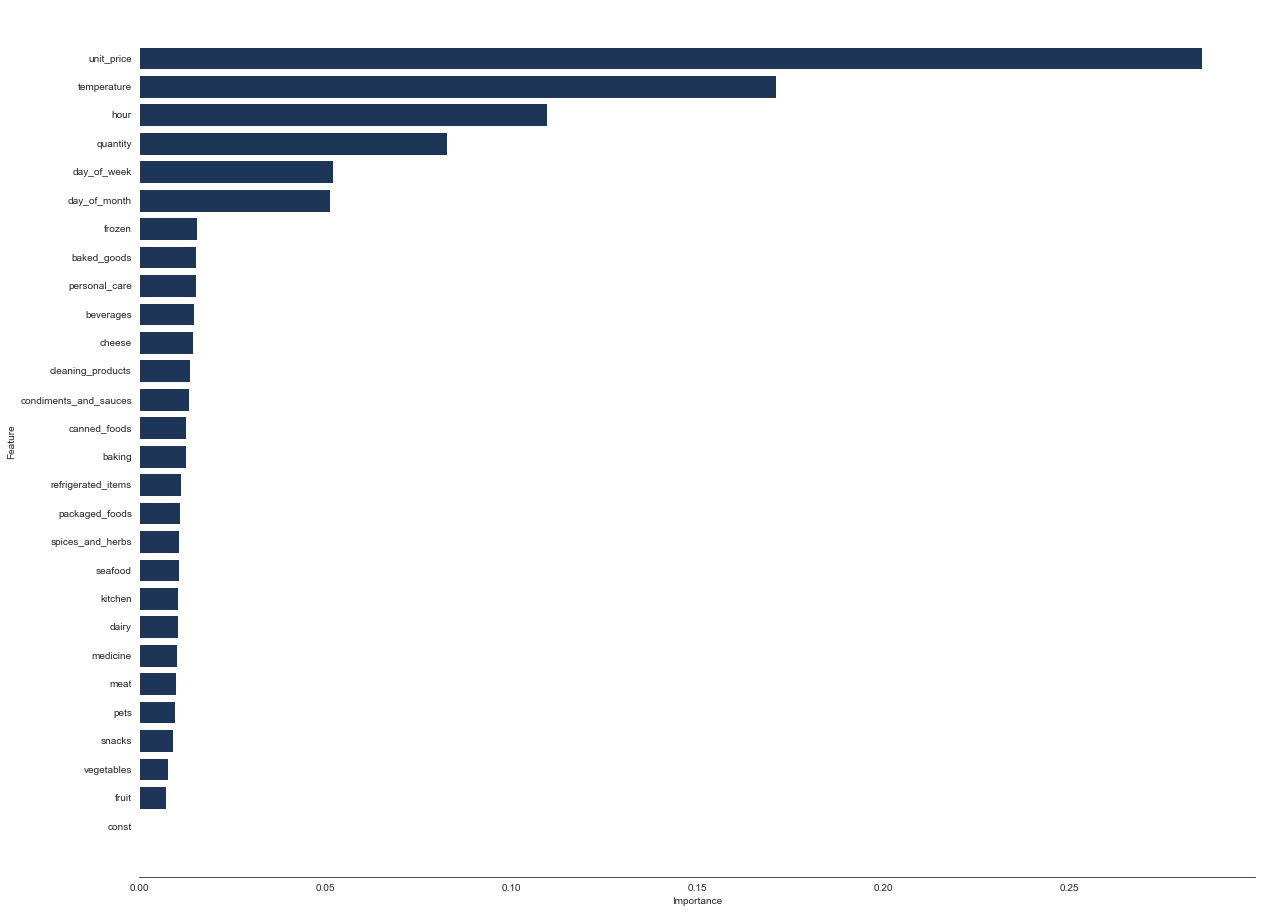

In [54]:
importances = rf_model.feature_importances_
features = X_train_transformed_df.columns

# Sort feature importances in descending order
indices = np.argsort(importances)[::1]

# Rearrange feature names so they match the sorted feature importances
names = [features[i] for i in indices]

# Create horizontal bar plot
plt.figure(figsize=(20, 16))
sns.set_style("white")
plt.barh(range(X_train_transformed_df.shape[1]), importances[indices], color='#1D3557')
plt.yticks(range(X_train_transformed_df.shape[1]), names)
plt.xlabel('Importance')
plt.ylabel('Feature')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.tick_params(bottom = False, left = False)
plt.show()

We can see that unit_price, temperature, hour and quantity are the most important features to predict the model

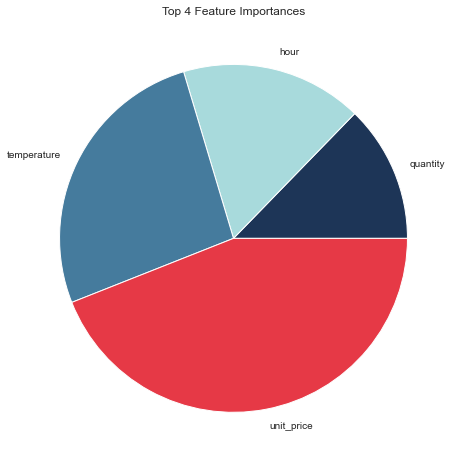

In [69]:
# Get top 4 features and their importances
top_features = names[-4:]
top_importances = importances[indices][-4:]

# Plot pie chart
plt.figure(figsize=(8, 8))
sns.set_style("white")
plt.pie(top_importances, labels=top_features, colors=['#1D3557','#A8DADC','#457B9D','#E63946'])
plt.title('Top 4 Feature Importances')
plt.show()

